# Predictive model for health and safety inspections.

# Training and testing

## Note: remember to start postgresql server!

In [1]:
## Python packages
import random
import time
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from class_imb import downsample
from osha import sic_division, fopi

In [2]:
# Database name and username
dbname = 'osha_db'
username = 'asc'

# Connection to SQL database
conn = None
conn = psycopg2.connect(database = dbname, user = username)

# Selecting potentially useful data for analysis

In [ ]:
# 
usa_all_query = '''
SELECT * FROM inspections_table;
'''

#
usa_4plus1_query = '''
SELECT 
owner_type, nr_in_estab, union_status, sic_code, is_violation
FROM inspections_table;
'''

#
usa_6plus1_query = '''
SELECT 
open_date, owner_type, nr_in_estab, union_status, sic_code, site_state, is_violation
FROM inspections_table;
'''

#
nyc_all_query = sql_query = '''
SELECT * FROM inspections_table
WHERE site_city='New York' OR site_city='NEW YORK' OR site_city='new york' 
OR site_city='NEW YORK CITY' OR site_city='New York City' OR site_city='new york city'
OR site_city='Brooklyn' OR site_city='BROOKLYN' OR site_city='brooklyn' 
OR site_city='BRONX' OR site_city='Bronx' OR site_city='bronx'
OR site_city='STATEN ISLAND' OR site_city='Staten Island' OR site_city='staten island'
OR site_city='QUEENS' OR site_city='Queens' OR site_city='queens'
OR site_city='ASTORIA' OR site_city='Astoria' OR site_city='astoria'
OR site_city='LONG ISLAND CITY' OR site_city='Long Island City' OR site_city='long island city'
OR site_city='SUNNYSIDE' OR site_city='Sunnyside' OR site_city='sunnyside'
OR site_city='BAYSIDE' OR site_city='Bayside' OR site_city='bayside'
OR site_city='BELLEROSE' OR site_city='Bellerose' OR site_city='bellerose' 
OR site_city='COLLEGE POINT' OR site_city='College Point' OR site_city='college point'
OR site_city='DOUGLASTON' OR site_city='Douglaston' OR site_city='douglaston'
OR site_city='FLUSHING' OR site_city='Flushing' OR site_city='flushing'
OR site_city='POMONOK' OR site_city='Pomonok' OR site_city='pomonok'
OR site_city='FLORAL PARK' OR site_city='Floral Park' OR site_city='floral park'
OR site_city='FRESH MEADOWS' OR site_city='Fresh Meadows' OR site_city='fresh meadows'
OR site_city='FORT TOTTEN' OR site_city='Fort Totten' OR site_city='fort totten'
OR site_city='GLEN OAKS' OR site_city='Glen Oaks' OR site_city='glen oaks'
OR site_city='LITTLE NECK' OR site_city='Little Neck' OR site_city='little neck'
OR site_city='WHITESTONE' OR site_city='Whitestone' OR site_city='whitestone'
OR site_city='CORONA' OR site_city='Corona' OR site_city='corona'
OR site_city='EAST ELMHURST' OR site_city='East Elmhurst' OR site_city='east elmhurst'
OR site_city='FOREST HILLS' OR site_city='Forest Hills' OR site_city='forest hills'
OR site_city='FRESH POND' OR site_city='Fresh Pond' OR site_city='fresh pond'
OR site_city='GLENDALE' OR site_city='Glendale' OR site_city='glendale'
OR site_city='JACKSON HEIGHTS' OR site_city='Jackson Heights' OR site_city='jackson heights'
OR site_city='KEW GARDENS' OR site_city='Kew Gardens' OR site_city='kew gardens'
OR site_city='MASPETH' OR site_city='Maspeth' OR site_city='maspeth'
OR site_city='MIDDLE VILLAGE' OR site_city='Middle Village' OR site_city='middle village'
OR site_city='REGO PARK' OR site_city='Rego Park' OR site_city='rego park'
OR site_city='RIDGEWOOD' OR site_city='Ridgewood' OR site_city='ridgewood'
OR site_city='WOODSIDE' OR site_city='Woodside' OR site_city='woodside'
OR site_city='BELLAIRE' OR site_city='Bellaire' OR site_city='bellaire'
OR site_city='BROOKVILLE' OR site_city='Brookville' OR site_city='brookville'
OR site_city='CAMBRIA HEIGHTS' OR site_city='Cambria Heights' OR site_city='cambria heights'
OR site_city='HOLLIS HILLS' OR site_city='Hollis Hills' OR site_city='hollis hills' 
OR site_city='HOLLIS' OR site_city='Hollis' OR site_city='hollis'
OR site_city='JAMAICA' OR site_city='Jamaica' OR site_city='jamaica'
OR site_city='LAURELTON' OR site_city='Laurelton' OR site_city='laurelton'
OR site_city='MEADOWMERE' OR site_city='Meadowmere' OR site_city='meadowmere'
OR site_city='QUEENS VILLAGE' OR site_city='Queens Village' OR site_city='queens village'
OR site_city='ROCHDALE VILLAGE' OR site_city='Rochdale Village' OR site_city='rochdale village'
OR site_city='ROSEDALE' OR site_city='Rosedale' OR site_city='rosedale'
OR site_city='SAINT ALBANS' OR site_city='Saint Albans' OR site_city='saint albans'
OR site_city='SOUTH JAMAICA' OR site_city='South Jamaica' OR site_city='south jamaica'
OR site_city='SPRINGDIELD GARDENS' OR site_city='Springfield Gardens' OR site_city='springfield gardens'
OR site_city='WARNERVILLE' OR site_city='Warnerville' OR site_city='warnerville'
OR site_city='THE HOLE' OR site_city='The Hole' OR site_city='the hole'
OR site_city='HOWARD BEACH' OR site_city='Howard Beach' OR site_city='howard beach'
OR site_city='OZONE PARK' OR site_city='Ozone Park' OR site_city='ozone park'
OR site_city='RICHMOND HILL' OR site_city='Richmond Hill' OR site_city='richmond hill'
OR site_city='WOODHAVEN' OR site_city='Woodhaven' OR site_city='woodhaven'
OR site_city='ARVERNE' OR site_city='Arverne' OR site_city='arverne'
OR site_city='BAYSWATER' OR site_city='Bayswater' OR site_city='bayswater'
OR site_city='BELLE HARBOR' OR site_city='Belle Harbor' OR site_city='belle harbor'
OR site_city='BREEZY POINT' OR site_city='Breezy Point' OR site_city='breezy point'
OR site_city='BROAD CHANNEL' OR site_city='Broad Channel' OR site_city='broad channel'
OR site_city='EDGEMERE' OR site_city='Edgemere' OR site_city='edgemere'
OR site_city='FAR ROCKAWAY' OR site_city='Far Rockaway' OR site_city='far rockaway'
OR site_city='HAMMELS' OR site_city='Hammels' OR site_city='hammels'
OR site_city='NEPONSIT' OR site_city='Neponsit' OR site_city='neponsit'
OR site_city='ROCKAWAY' OR site_city='Rockaway' OR site_city='rockaway'
OR site_city='ROCKAWAY BEACH' OR site_city='Rockaway Beach' OR site_city='rockaway beach'
OR site_city='ROCKAWAY PARK' OR site_city='Rockaway Park' OR site_city='rockaway park'
OR site_city='ROXBURY' OR site_city='Roxbury' OR site_city='roxbury'
OR site_city='SEASIDE' OR site_city='Seaside' OR site_city='seaside'
AND site_state='NY';
'''

# 
vegas_4plus1_query = '''
SELECT owner_type, nr_in_estab, union_status, sic_code, is_violation 
FROM inspections_table
WHERE site_city='Las Vegas' OR site_city='LAS VEGAS' OR site_city='las vegas' 
AND site_state='NV';
'''

# 
forthoursands_4plus1_query = '''
SELECT owner_type, nr_in_estab, union_status, adv_notice, is_violation
FROM inspections_table
WHERE sic_code>=4000 AND sic_code<=4999;
'''

In [3]:
#
usa_6plus1_query = '''
SELECT 
open_date, owner_type, nr_in_estab, union_status, sic_code, site_state, is_violation
FROM inspections_table;
'''

In [4]:
# Query from database

sql_query = usa_6plus1_query

my_data = pd.read_sql_query(sql_query, conn)
#my_data.columns

In [5]:
from osha import fopi
print "Violation fraction over entire dataset:", fopi(my_data, 'is_violation')

Violation fraction over entire dataset: 0.255160867857


# Data transformations

In [6]:
# Missing values

# Fill NaN with zeroes or drop in number of employees

method="drop" #"fill"

if(method=="fill"):
    my_data['nr_in_estab'].fillna(0, inplace=True)
elif(method=="drop"):
    my_data.dropna(axis=0, inplace=True)
elif(method=="median"):
    my_data['nr_in_estab'].fillna(my_data['nr_in_estab'].median(), inplace=True)

In [7]:
print "Violation fraction over entire dataset:", fopi(my_data, 'is_violation')

Violation fraction over entire dataset: 0.291847348591


In [8]:
# Aggregate SIC numbers by division
from osha import sic_division
my_data['sic_code'] = my_data['sic_code'].apply(sic_division)

In [9]:
# Select data from 1996-2015

start_date = '1996-1-1'
end_date   = '2016-1-1'

# Dataframe must be Series with dtype datetime64[ns]
my_data['open_date'] = pd.to_datetime(my_data['open_date'])  
mask = (my_data['open_date'] > start_date) & (my_data['open_date'] <= end_date)
my_data = my_data.loc[mask]

In [10]:
print "Violation fraction for years 1996-2015:", fopi(my_data, 'is_violation')

Violation fraction for years 1996-2015: 0.353422242022


In [11]:
# Now discard date column
XY = my_data.drop('open_date', axis=1)

In [12]:
# Create dummies for all categorical variables
XY = pd.get_dummies(XY, columns=[
    'sic_code', 
    'owner_type', 
    'union_status',
    'site_state',
    ])

In [13]:
# Downsample imbalanced data
from class_imb import downsample
XY = downsample(XY, 'is_violation')

In [16]:
print "Violation fraction after downsampling:", fopi(XY, 'is_violation')

Violation fraction after downsampling: 0.5


### Split into train and test sets for later use

In [15]:

from sklearn.model_selection import train_test_split

test_fraction = 0.20

X = XY.drop('is_violation', axis=1)
Y = XY['is_violation']

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, 
    test_size=test_fraction, 
    random_state=np.random.seed(int(time.time())))

p1_train = float(sum(y_train))/y_train.shape[0] 
p1_test = float(sum(y_test))/y_test.shape[0]
print "Proportions of class 1"
print "   Training data: ", p1_train
print "   Test data:     ", p1_test

Proportions of class 1
   Training data:  0.50010311851
   Test data:      0.499587526811


In [ ]:
import pickle

def load_model(filename):
    '''
    Load model from pickle file.

    Input:
     - filename: str containing pickle file name

    Output: sklearn model object

    '''   
    return pickle.load(open(filename, 'rb'))
    

    
def prepare_features(x_in):
    '''
    Prepare input for model

    '''
    
    # Separate string into list and remove spaces
    x = [aux.strip() for aux in x_in.split(',')]

    
    # Create dictionary with zeros in all entries
    d = {
    'sic_code_A':0, 'sic_code_B':0,'sic_code_C':0, 
    'sic_code_D':0, 'sic_code_E':0, 'sic_code_F':0,
    'sic_code_G':0, 'sic_code_H':0, 'sic_code_I':0, 
    'sic_code_J':0, 'sic_code_K':0, 
    'owner_type_A':0, 'owner_type_B':0, 'owner_type_C':0, 'owner_type_D':0, 
    'union_status_N':0, 'union_status_Y':0,
    'nr_in_estab':0}
    
    
    # Split SIC by division
    sic_div = sic_division(int(x[0]))
    
    
    # Check cases and fill dictionary
    #
    # 1) SIC division
    if (sic_div=='A'):
        d['sic_code_A']=1
    elif(sic_div=='B'):
        d['sic_code_B']=1
    elif(sic_div=='C'):
        d['sic_code_C']=1
    elif(sic_div=='D'):
        d['sic_code_D']=1
    elif(sic_div=='E'):
        d['sic_code_E']=1
    elif(sic_div=='F'):
        d['sic_code_F']=1
    elif(sic_div=='G'):
        d['sic_code_G']=1
    elif(sic_div=='H'):
        d['sic_code_H']=1
    elif(sic_div=='I'):
        d['sic_code_I']=1
    elif(sic_div=='J'):
        d['sic_code_J']=1
    elif(sic_div=='K'):
        d['sic_code_K']=1
        
    # 2) owner type
    owner = x[1]
    if (owner=='A'):
        d['owner_type_A']=1
    elif(owner=='B'):
        d['owner_type_B']=1
    elif(owner=='C'):
        d['owner_type_C']=1
    elif(owner=='D'):
        d['owner_type_D']=1
        
    # 3) union status
    us = x[2]
    if (us=='Y'):
        d['union_status_Y']=1
    elif(us=='N'):
        d['union_status_N']=1
        
    # 4) number of employees in establishment
    d['nr_in_estab'] =  int(x[3])
    
    
    # Create dataframe
    df = pd.DataFrame([d])
    
    # Group SIC codes by division
    #df['sic_code'] = df['sic_code'].apply(sic_division)

    
    
    x_out = df[[
    'sic_code_A', 'sic_code_B','sic_code_C', 
    'sic_code_D', 'sic_code_E', 'sic_code_F',
    'sic_code_G', 'sic_code_H', 'sic_code_I', 
    'sic_code_J', 'sic_code_K', 
    'owner_type_A', 'owner_type_B', 'owner_type_C', 'owner_type_D', 
    'union_status_N', 'union_status_Y',
    'nr_in_estab' 
    ]] 

    x_out
    
    # Return dataframe with created dummies
    return x_out



def predict(model_pickle, x_string):
    '''
    Evaluate model on given data vector x

    Input:
     - model_pickle: pickle file containing 
                     sklearn model object 
     -     x_string: input string 

    Output: model probability P(x in 1)

    '''
    
    model = load_model(model_pickle)
    x = prepare_features(x_string)
    
    
    return model.predict_proba(x)[0,1]

In [ ]:
trash='3200, A , N, 2'
predict('./trained_RF.sav', trash)

# Hyperparameter search

In [17]:
from time import time

def print_RSCV_results(results, n_top=3):
    '''
    Print results of Randomized Search CV
    
    INPUT
      - results : results object of RandomizedSearchCV
      - n_top   : number of models to display, from highest to lowest metric
    
    OUTPUT
      - none
    '''
    
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print "Model with rank: {0}".format(i)
            print "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                results['mean_test_score'][candidate],
                results['std_test_score'][candidate])
            print "Parameters: {0}".format(results['params'][candidate])
            print ""# specify parameters and distributions to sample from
        

In [197]:
# Utility function to report best scores of random search of hyperparameters

from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


# Initialize classifier instance
clf = RandomForestClassifier()
        
# Dictionary containing hyperparameter values.
# Keys coincide with RF variable names
param_dist = {"max_depth": [9,11,13],
             "max_features": sp_randint(np.floor(0.25*X.shape[1]), X.shape[1]),  # in range (Nfeat/4, Nfeat)
             "min_samples_split": sp_randint(30, 200),
             "min_samples_leaf": sp_randint(1, 11),
             "bootstrap": [True, False],
             "criterion": ["gini", "entropy"]} # run randomized search

n_iter_search = 25
random_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_dist,
    scoring="accuracy",
    n_iter=n_iter_search,
    n_jobs=2,
    verbose=2)


# X_train, X_test, y_train, y_test
start = time()
random_search.fit(X, Y)
#print "RandomizedSearchCV took %.2f seconds for %d candidates", " parameter settings." % ((time() - start), n_iter_search)
print "Elapsed time: ", (time() - start), "seconds for ", n_iter_search ,"hyperparameter choices"

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] bootstrap=False, min_samples_leaf=9, max_features=62, criterion=entropy, min_samples_split=65, max_depth=9 
[CV] bootstrap=False, min_samples_leaf=9, max_features=62, criterion=entropy, min_samples_split=65, max_depth=9 
[CV]  bootstrap=False, min_samples_leaf=9, max_features=62, criterion=entropy, min_samples_split=65, max_depth=9, total= 3.3min
[CV] bootstrap=False, min_samples_leaf=9, max_features=62, criterion=entropy, min_samples_split=65, max_depth=9 
[CV]  bootstrap=False, min_samples_leaf=9, max_features=62, criterion=entropy, min_samples_split=65, max_depth=9, total= 3.3min
[CV] bootstrap=False, min_samples_leaf=8, max_features=22, criterion=gini, min_samples_split=165, max_depth=13 
[CV]  bootstrap=False, min_samples_leaf=8, max_features=22, criterion=gini, min_samples_split=165, max_depth=13, total= 2.6min
[CV] bootstrap=False, min_samples_leaf=8, max_features=22, criterion=gini, min_samples_split=165, max_dep

[CV]  bootstrap=True, min_samples_leaf=7, max_features=36, criterion=entropy, min_samples_split=162, max_depth=11, total= 1.8min
[CV] bootstrap=True, min_samples_leaf=7, max_features=36, criterion=entropy, min_samples_split=162, max_depth=11 
[CV]  bootstrap=True, min_samples_leaf=7, max_features=36, criterion=entropy, min_samples_split=162, max_depth=11, total= 1.8min
[CV] bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11 
[CV]  bootstrap=True, min_samples_leaf=7, max_features=36, criterion=entropy, min_samples_split=162, max_depth=11, total= 1.8min
[CV] bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11 
[CV]  bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11, total= 3.4min


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 44.6min


[CV] bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11 
[CV]  bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11, total= 3.4min
[CV] bootstrap=False, min_samples_leaf=5, max_features=20, criterion=entropy, min_samples_split=115, max_depth=9 
[CV]  bootstrap=False, min_samples_leaf=5, max_features=20, criterion=entropy, min_samples_split=115, max_depth=9, total= 1.0min
[CV] bootstrap=False, min_samples_leaf=5, max_features=20, criterion=entropy, min_samples_split=115, max_depth=9 
[CV]  bootstrap=False, min_samples_leaf=5, max_features=20, criterion=entropy, min_samples_split=115, max_depth=9, total= 1.1min
[CV] bootstrap=False, min_samples_leaf=5, max_features=20, criterion=entropy, min_samples_split=115, max_depth=9 
[CV]  bootstrap=False, min_samples_leaf=6, max_features=63, criterion=entropy, min_samples_split=124, max_depth=11, total= 2.9min
[CV] bootstrap=False, min

[CV]  bootstrap=True, min_samples_leaf=1, max_features=36, criterion=entropy, min_samples_split=109, max_depth=13, total= 3.6min
[CV] bootstrap=True, min_samples_leaf=1, max_features=54, criterion=gini, min_samples_split=81, max_depth=11 
[CV]  bootstrap=True, min_samples_leaf=1, max_features=54, criterion=gini, min_samples_split=81, max_depth=11, total= 4.2min
[CV] bootstrap=True, min_samples_leaf=1, max_features=54, criterion=gini, min_samples_split=81, max_depth=11 
[CV]  bootstrap=True, min_samples_leaf=1, max_features=54, criterion=gini, min_samples_split=81, max_depth=11, total= 3.1min
[CV]  bootstrap=True, min_samples_leaf=1, max_features=54, criterion=gini, min_samples_split=81, max_depth=11, total= 2.7min


[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed: 93.4min finished


Elapsed time:  5754.90136504 seconds for  25 hyperparameter choices


In [198]:
print_RSCV_results(random_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.652 (std: 0.001)
Parameters: {'bootstrap': False, 'min_samples_leaf': 8, 'min_samples_split': 156, 'criterion': 'gini', 'max_features': 38, 'max_depth': 13}

Model with rank: 2
Mean validation score: 0.652 (std: 0.002)
Parameters: {'bootstrap': True, 'min_samples_leaf': 8, 'min_samples_split': 52, 'criterion': 'gini', 'max_features': 36, 'max_depth': 13}

Model with rank: 3
Mean validation score: 0.652 (std: 0.001)
Parameters: {'bootstrap': False, 'min_samples_leaf': 5, 'min_samples_split': 111, 'criterion': 'entropy', 'max_features': 62, 'max_depth': 13}

Model with rank: 4
Mean validation score: 0.651 (std: 0.002)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 109, 'criterion': 'entropy', 'max_features': 36, 'max_depth': 13}

Model with rank: 5
Mean validation score: 0.651 (std: 0.001)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 115, 'criterion': 'gini', 'max_features': 25, 'max_d

### Assessing model metrics for optimal hyperparameters

#### Train model

In [199]:
# Retrain model with optimal parameters
from sklearn.ensemble import RandomForestClassifier


# Optimal parameter values
optparams = random_search.cv_results_['params'][np.argmin(random_search.cv_results_['rank_test_score'])]


clf = RandomForestClassifier(n_jobs=2, n_estimators=30,
    bootstrap         = optparams['bootstrap'],
    min_samples_leaf  = optparams['min_samples_leaf'],
    min_samples_split = optparams['min_samples_split'], 
    criterion         = optparams['criterion'], 
    max_features      = optparams['max_features'], 
    max_depth         = optparams['max_depth']
    ) #, random_state=0)


clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=13, max_features=38, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=8,
            min_samples_split=156, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=2, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [200]:
# save the model to disk
import pickle
filename = './trained_RF.sav'
pickle.dump(clf, open(filename, 'wb'))

#### Compute metrics for model on test data

In [201]:

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score

y_pred = clf.predict(X_test)

apr = [
    accuracy_score(y_test, y_pred), 
    precision_score(y_test, y_pred), 
    recall_score(y_test, y_pred)]  


print "  accuracy:  ", apr[0] # can also be computed with clf.score(X_test, y_test)
print "  precision: ", apr[1]
print "  recall:    ", apr[2]

# ROC (receiver operating characteristic) AUC (area under the curve) is insensitive of unbalanced classes
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
print "  AUC:       ", auc    


  accuracy:   0.652243854149
  precision:  0.630135049141
  recall:     0.735799207398
  AUC:        0.700652017489


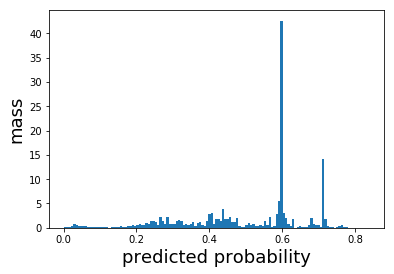

In [202]:
# Probabilities of positive class
pred_prob = clf.predict_proba(X_test)[:,1]
height, edges, patches = plt.hist(pred_prob, bins='auto', normed='true')

fs = 18

plt.xlabel('predicted probability', fontsize=fs)
plt.ylabel('mass', fontsize=fs)

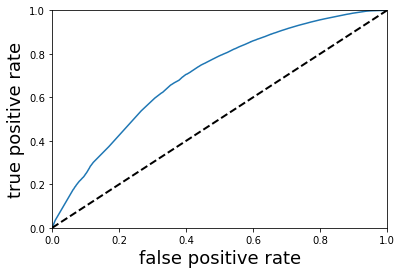

In [203]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob)#, pos_label=2)

# 
lw = 2
fs = 18
plt.plot(fpr, tpr)#, label='RT + LR')
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('false positive rate', fontsize=fs )
plt.ylabel('true positive rate', fontsize=fs )
#plt.title('receiver operating characteristic')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('usa1996-2015_roc_curve.png',  bbox_inches='tight')

In [204]:
# Compute feature importance
feat_imp = clf.feature_importances_
num_feat = len(feat_imp)

# Sort in ascending order
index_sorted = np.flip(np.argsort(feat_imp), 0)
feat_imp = feat_imp[index_sorted]
feature_labels = X_test.columns[index_sorted]

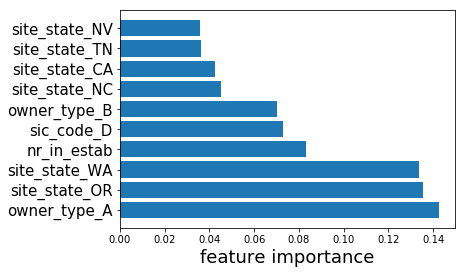

In [205]:
# Plot feature importance

fs=18

Nbars= 10# np.shape(clf.feature_importances_)[0]

fig, ax = plt.subplots()


ax.barh(np.arange(0,Nbars), feat_imp[0:Nbars])
ax.set_yticks(np.arange(0,Nbars))


ax.set_yticklabels(feature_labels, fontsize=fs-3) #, rotation='vertical')



ax.set_xlabel('feature importance', fontsize=fs)
#ax.set_title('Feature', fontsize=fs)
plt.savefig('feature_importance_all.png',  bbox_inches='tight', dpi=500)

In [206]:
# Aggregate features by type
imp = np.zeros(5)
lbls = [
    'number of workers', 
    'ind. sector', 
    'ownership type', 
    'US state',
    'union affiliation']

for i in range(0,np.shape(feat_imp)[0]):
    
    lbl=feature_labels.values[i] # These are already sorted
    
    if   lbl[0:3] == 'nr_':
        imp[0] += feat_imp[i]
    elif lbl[0:3] == 'sic':
        imp[1] += feat_imp[i]
    elif lbl[0:3] == 'own':
        imp[2] += feat_imp[i]
    elif lbl[0:3] == 'sit':
        imp[3] += feat_imp[i]
    elif lbl[0:3] == 'uni':
        imp[4] += feat_imp[i]


# Sort in ascending order
agg_index_sorted = np.flip(np.argsort(imp), 0)
agg_feat_imp = imp[agg_index_sorted]

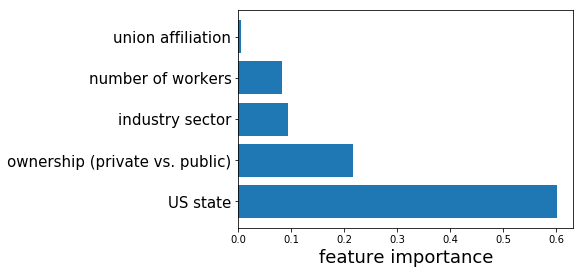

In [207]:
# Plot aggregated feature importance

fs=18

Nbars= len(imp)

fig, ax = plt.subplots()


ax.barh(np.arange(0,Nbars), imp[agg_index_sorted])
ax.set_yticks(np.arange(0,Nbars))

my_labels = ['number of workers', 
             'industry sector',
             'ownership (private vs. public)', 
             'US state', 
             'union affiliation']

ax.set_yticklabels(np.array(my_labels)[agg_index_sorted], fontsize=fs-3) #, rotation='vertical')



ax.set_xlabel('feature importance', fontsize=fs)
plt.savefig('feature_importance_grouped.png',  bbox_inches='tight', dpi=500)

#### Convergence of K-L divergence of p(p(1))
One hyperparameter that was not optimized was the number of estimators. We chose the value n_estimators=30. Is the model converged at that value or will we need more estimators?

In [208]:
# Kullbeck-Leibler divergence
def KL_div(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0 and b>1.0E-08, a * np.log(a / b), 0))

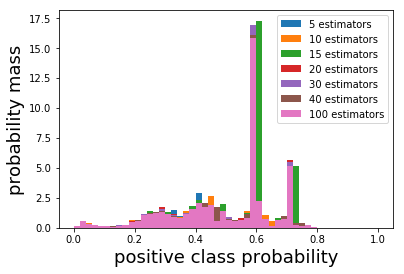

In [225]:
# Train and compute probabilities

Nbins = 50 # Bins for histograms
n_est = [5, 10, 15, 20, 30, 40, 100]

hbins=[]
for n in n_est:
    
    clf = RandomForestClassifier(n_jobs=2, n_estimators = n, 
        bootstrap         = optparams['bootstrap'],
        min_samples_leaf  = optparams['min_samples_leaf'],
        min_samples_split = optparams['min_samples_split'], 
        criterion         = optparams['criterion'], 
        max_features      = optparams['max_features'], 
        max_depth         = optparams['max_depth']
        )

    clf.fit(X_train, y_train)
    
    
    pred_prob = clf.predict_proba(X_test)[:,1]
    h, e, p = plt.hist(
        pred_prob, 
        bins=Nbins, 
        range=(0.0,1.0), 
        normed='true',
        label=str(n)+ ' estimators')

    
    hbins.append(h)

plt.xlabel('positive class probability', fontsize=fs)
plt.ylabel('probability mass', fontsize=fs)
plt.legend()
plt.savefig('./p1dist_nestimators.png')

In [226]:
# Kullbeck-Leibler divergence
def KL_div(p1, p2, threshold = 1.0E-07):
    '''
    Kullbeck-Leibler divervgence of distribution
    p1 to p2.
    '''
    p1 = np.asarray(p1, dtype=np.float)
    p2 = np.asarray(p2, dtype=np.float)
    
        
    # If there are zeros, remove.
    # Remove first zeros from p1
    p2 = np.extract(p1 > threshold, p2)
    p1 = np.extract(p1 > threshold, p1)
    
    # Now remove zeros from p2
    p1 = np.extract(p2 > threshold, p1)
    p2 = np.extract(p1 > threshold, p2)
        
    return np.sum(p1 * np.log(p1 / p2))
    

In [227]:
# From probabilities, compute KL divergences
# to the baseline (larger n_estiamators model)
KLs=np.zeros(len(hbins)-1)

for i in range(0,len(hbins)-1):
    p = hbins[i]
    q = hbins[len(hbins)-1]
    KLs[i] = KL_div(p,q)
    

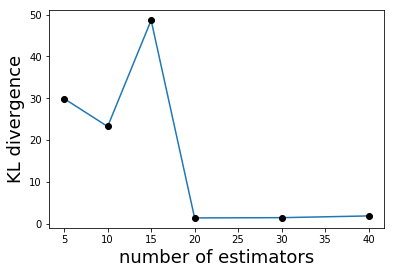

In [228]:
# Plot KL divergences
fs=18

plt.plot(n_est[0:len(hbins)-1], KLs, '-')
plt.plot(n_est[0:len(hbins)-1], KLs, 'o', color='k', markersize=6)
plt.xlabel('number of estimators', fontsize=fs)
plt.ylabel('KL divergence', fontsize=fs)
plt.savefig('./KLconvergence.png',  bbox_inches='tight', dpi=500)

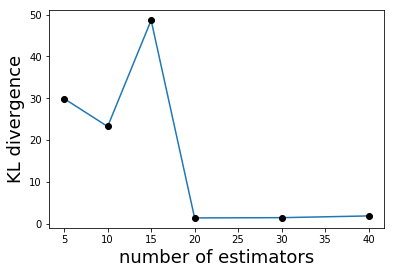

In [228]:
# Plot KL divergences
fs=18

plt.plot(n_est[0:len(hbins)-1], KLs, '-')
plt.plot(n_est[0:len(hbins)-1], KLs, 'o', color='k', markersize=6)
plt.xlabel('number of estimators', fontsize=fs)
plt.ylabel('KL divergence', fontsize=fs)
plt.savefig('./KLconvergence.png',  bbox_inches='tight', dpi=500)

*We observe that at n_estimators=30 the probability distribution relative to the baseline is well converged.*